## Import Necessary Libraries

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

In [2]:
print(torch.__version__)

2.0.1+cpu


## Exploratory Data Analysis (EDA)

In [4]:
data_dir = "./Dataset"
print(os.listdir(data_dir))

['AEP_hourly.csv', 'COMED_hourly.csv', 'DAYTON_hourly.csv', 'DEOK_hourly.csv', 'DOM_hourly.csv', 'DUQ_hourly.csv', 'EKPC_hourly.csv', 'FE_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv', 'PJMW_hourly.csv', 'PJM_Load_hourly.csv']


In [5]:
pd.read_csv(os.path.join(data_dir, "DEOK_hourly.csv")).head()

,Datetime,DEOK_MW
0,2012-12-31 01:00:00,2945.0
1,2012-12-31 02:00:00,2868.0
2,2012-12-31 03:00:00,2812.0
3,2012-12-31 04:00:00,2812.0
4,2012-12-31 05:00:00,2860.0


## Create training instances by sliding window method

In [6]:
def sliding_window(data, window_size, input_cols, label_cols):
    inputs = np.zeros((len(data) - window_size, window_size, len(input_cols)))
    labels = np.zeros(len(data) - window_size)

    for i in range(window_size, len(data)):
        inputs[i - window_size] = data[i - window_size:i, input_cols]
        labels[i - window_size] = data[i, label_cols]

    inputs = inputs.reshape(-1, window_size, len(input_cols))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

## Build Training dataset by merging all the input files

In [ ]:
label_cols = 0
input_cols = range(5)
window_size = 90

label_scalers = {}

x_train = []
x_test = {}
y_test = {}

processing_files = [
    file for file in os.listdir(data_dir) if os.path.splitext(file)[1] == ".csv"
]

num_files_for_data = 5

for file in tqdm_notebook(processing_files[:num_files_for_data]):
    print(f"Processing {file}.................")
    df = pd.read_csv(os.path.join(data_dir, file), parse_dates=['Datetime'])
    df['hour'] = df.apply(lambda x: x['Datetime'].hour, axis=1)
    df['dayofweek'] = df.apply(lambda x: x['Datetime'].dayofweek, axis=1)
    df['month'] = df.apply(lambda x: x['Datetime'].month, axis=1)
    df['dayofyear'] = df.apply(lambda x: x['Datetime'].dayofyear, axis=1)
    df = df.sort_values('Datetime').drop('Datetime', axis=1)

    scaler = MinMaxScaler()
    label_scaler = MinMaxScaler()
    data = scaler.fit_transform(df.values)

    label_scaler.fit(df.iloc[:, label_cols].values.reshape(-1, 1))
    label_scalers[file] = label_scaler

    inputs, labels = sliding_window(
        data,
        window_size,
        input_cols,
        label_cols
    )

    test = int(0.2 * len(inputs))

    if len(x_train) == 0:
        x_train = inputs[:-test]
        y_train = labels[:-test]
    else:
        x_train = np.concatenate((x_train, inputs[:-test]))
        y_train = np.concatenate((y_train, labels[:-test]))

    x_test[file] = inputs[-test:]
    y_test[file] = labels[-test:]

In [8]:
x_train.shape, x_test['DEOK_hourly.csv'].shape

((386021, 90, 5), (11529, 90, 5))

In [9]:
y_train.shape

(386021, 1)

## PyTorch Dataloaders

In [10]:
batch_size = 1024

train = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))

train_loader = DataLoader(
    train, shuffle=True, batch_size=batch_size, drop_last=True
)

In [11]:
print(f"Train Size: {x_train.shape}, Batch Size: {batch_size}, No. of iterations per epoch: {int(x_train.shape[0]/batch_size)}")

Train Size: (386021, 90, 5), Batch Size: 1024, No. of iterations per epoch: 376


In [12]:
del x_train, y_train

In [19]:
is_cuda =torch.cuda.is_available()

if is_cuda:
    device = torch.device('cuda')
    print("GPU is available")
else:
    device = torch.device('cpu')

## GRU Architecture

In [13]:
class GRU(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
      super(GRU, self).__init__()
      self.hidden_dim = hidden_dim
      self.n_layers = n_layers

      self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first = True, dropout = drop_prob)
      self.fc = nn.Linear(hidden_dim, output_dim)
      self.relu = nn.ReLU()

  def forward(self, x, h):
    out, h = self.gru(x, h)
    out = self.fc(self.relu(out[:,-1]))
    return out, h

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
    return hidden

## LSTM Architecture

In [14]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
     super(LSTM, self).__init__()
     self.hidden_dim = hidden_dim
     self.n_layers = n_layers

     self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first = True, dropout = drop_prob)
     self.fc = nn.Linear(hidden_dim, output_dim)
     self.relu = nn.ReLU()

  def forward(self, x, h):
    out, h = self.lstm(x, h)
    out = self.fc(self.relu(out[:,-1]))
    return out, h

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    hidden = (
        weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
    )
    return hidden

In [15]:
def model_train(train_loader, learning_rate, hidden_dim=256, n_layers=2, n_epochs=5, model_type="GRU", print_every=100):
  input_dim = next(iter(train_loader))[0].shape[2]
  output_dim = 1

  if model_type == "GRU":
    model = GRU(input_dim, hidden_dim, output_dim, n_layers)
  else:
    model = LSTM(input_dim, hidden_dim, output_dim, n_layers)
  model.to(device)

  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  model.train()

  print(f"Training started of {model_type} Model")
  epochs_times = []

  for epoch in range(1, n_epochs+1):
    start_time = time.process_time()
    h = model.init_hidden(batch_size)
    avg_loss = 0.0
    counter = 0
    for x, label in train_loader:
      counter += 1
      if model_type == "GRU":
        h = h.data
      else:
        h = tuple([e.data for e in h])
      model.zero_grad()

      out, h = model(x.to(device).float(), h)
      loss = criterion(out, label.to(device).float())

      loss.backward()
      optimizer.step()

      avg_loss += loss.item()
      if counter % print_every == 0:
        print(f"Epoch {epoch} - Step: {counter}/{len(train_loader)} - Average Loss: {loss.item()}")

    current_time = time.process_time()

    print(f"Epoch {epoch}/{n_epochs} Done, Total Loss: {avg_loss/len(train_loader)}")
    print(f"Time Elapsed for Epoch: {current_time - start_time} seconds")
    epochs_times.append(current_time - start_time)

  print(f"Time Elapsed for Training: {sum(epoch_times)} seconds")
  return model

## GRU Model Training

In [ ]:
n_hidden = 256
n_layers = 2
n_epochs = 5
print_every = 100
lr = 0.001
gru_model = model_train(train_loader, lr, n_hidden, n_layers, n_epochs, "GRU", print_every)

Training started of GRU Model
Epoch 1 - Step: 100/454 - Average Loss: 0.001675126259215176
Epoch 1 - Step: 200/454 - Average Loss: 0.001123244990594685
Epoch 1 - Step: 300/454 - Average Loss: 0.0008642385946586728
Epoch 1 - Step: 400/454 - Average Loss: 0.0005631477106362581
Epoch 1/5 Done, Total Loss: 1.0734030516358659e-06
Epoch 2 - Step: 100/454 - Average Loss: 0.0004942248924635351
Epoch 2 - Step: 200/454 - Average Loss: 0.0003592470893636346
Epoch 2 - Step: 300/454 - Average Loss: 0.00037218633224256337
Epoch 2 - Step: 400/454 - Average Loss: 0.00029811589047312737
Epoch 2/5 Done, Total Loss: 6.220762983030159e-07
Epoch 3 - Step: 100/454 - Average Loss: 0.00029957416700199246
Epoch 3 - Step: 200/454 - Average Loss: 0.00030897423857823014
Epoch 3 - Step: 300/454 - Average Loss: 0.00022910120605956763
Epoch 3 - Step: 400/454 - Average Loss: 0.0002311207354068756
Epoch 3/5 Done, Total Loss: 3.8342302950255016e-07
Epoch 4 - Step: 100/454 - Average Loss: 0.00026535772485658526
Epoch 4 

In [ ]:
torch.save(gru_model.state_dict(), "/content/Models/gru_model.pt")

## LSTM Model Training

In [ ]:
lstm_model = model_train(train_loader, lr, n_hidden, n_layers, n_epochs, "LSTM", print_every)

Training started of LSTM Model
Epoch 1 - Step: 100/454 - Average Loss: 0.004854422062635422
Epoch 1 - Step: 200/454 - Average Loss: 0.0024562347680330276
Epoch 1 - Step: 300/454 - Average Loss: 0.001624296186491847
Epoch 1 - Step: 400/454 - Average Loss: 0.0010000986512750387
Epoch 1/5 Done, Total Loss: 1.7696146910706544e-06
Epoch 2 - Step: 100/454 - Average Loss: 0.0007778180297464132
Epoch 2 - Step: 200/454 - Average Loss: 0.0006245673866942525
Epoch 2 - Step: 300/454 - Average Loss: 0.0006261727539822459
Epoch 2 - Step: 400/454 - Average Loss: 0.0005230918759480119
Epoch 2/5 Done, Total Loss: 9.631172913877449e-07
Epoch 3 - Step: 100/454 - Average Loss: 0.00044230668572708964
Epoch 3 - Step: 200/454 - Average Loss: 0.0003603562945500016
Epoch 3 - Step: 300/454 - Average Loss: 0.0003933878324460238
Epoch 3 - Step: 400/454 - Average Loss: 0.00037213979521766305
Epoch 3/5 Done, Total Loss: 6.672736495273754e-07
Epoch 4 - Step: 100/454 - Average Loss: 0.0002768128179013729
Epoch 4 - St

In [ ]:
torch.save(lstm_model.state_dict(), "/content/Models/lstm_model.pt")

## Model Evaluation

In [24]:
device = torch.device("cpu")

In [25]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
gru_model = GRU(input_dim, hidden_dim, output_dim, n_layers)
gru_model.load_state_dict(torch.load("./Models/gru_model.pt", map_location=device))
gru_model.to(device)

GRU(
  (gru): GRU(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

In [27]:
lstm_model = LSTM(input_dim, hidden_dim, output_dim, n_layers)
lstm_model.load_state_dict(torch.load("./Models/lstm_model.pt", map_location=device))
lstm_model.to(device)

LSTM(
  (lstm): LSTM(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

In [28]:
def MAPE(outputs, targets):
  sMAPE = (
      100/len(targets)*np.sum(np.abs(outputs - targets) / (np.abs(outputs + targets)) / 2)
  )

  return sMAPE

In [29]:
def evaluate(model, x_test, y_test, label_scalers):
  model.eval()
  outputs = []
  targets = []
  start_time = time.process_time()

  for file in x_test.keys():
    inputs = torch.from_numpy(np.array(x_test[file]))
    labels = torch.from_numpy(np.array(y_test[file]))

    h = model.init_hidden(inputs.shape[0])

    with torch.no_grad():
      out, h = model(inputs.to(device).float(), h)

    outputs.append(
        label_scalers[file].inverse_transform(out.cpu().detach().numpy()).reshape(-1)
    )

    targets.append(
        label_scalers[file].inverse_transform(labels.numpy()).reshape(-1)
    )

  concatenate_outputs = np.concatenate(outputs)
  concatenate_targets = np.concatenate(targets)

  print(f"Evaluation Time: {time.process_time() - start_time}")
  print(f"sMAPE: {round(MAPE(concatenate_outputs, concatenate_targets), 3)}%")

  return outputs, targets, MAPE

In [30]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, x_test, y_test, label_scalers)

Evaluation Time: 822.65625
sMAPE: 0.314%


In [31]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, x_test, y_test, label_scalers)

Evaluation Time: 594.65625
sMAPE: 0.337%


In [32]:
len(gru_outputs)

5

In [33]:
states_list = list(x_test.keys())
states_list

['AEP_hourly.csv',
 'COMED_hourly.csv',
 'DAYTON_hourly.csv',
 'DEOK_hourly.csv',
 'DOM_hourly.csv']

## Visualisations for Model Comparison

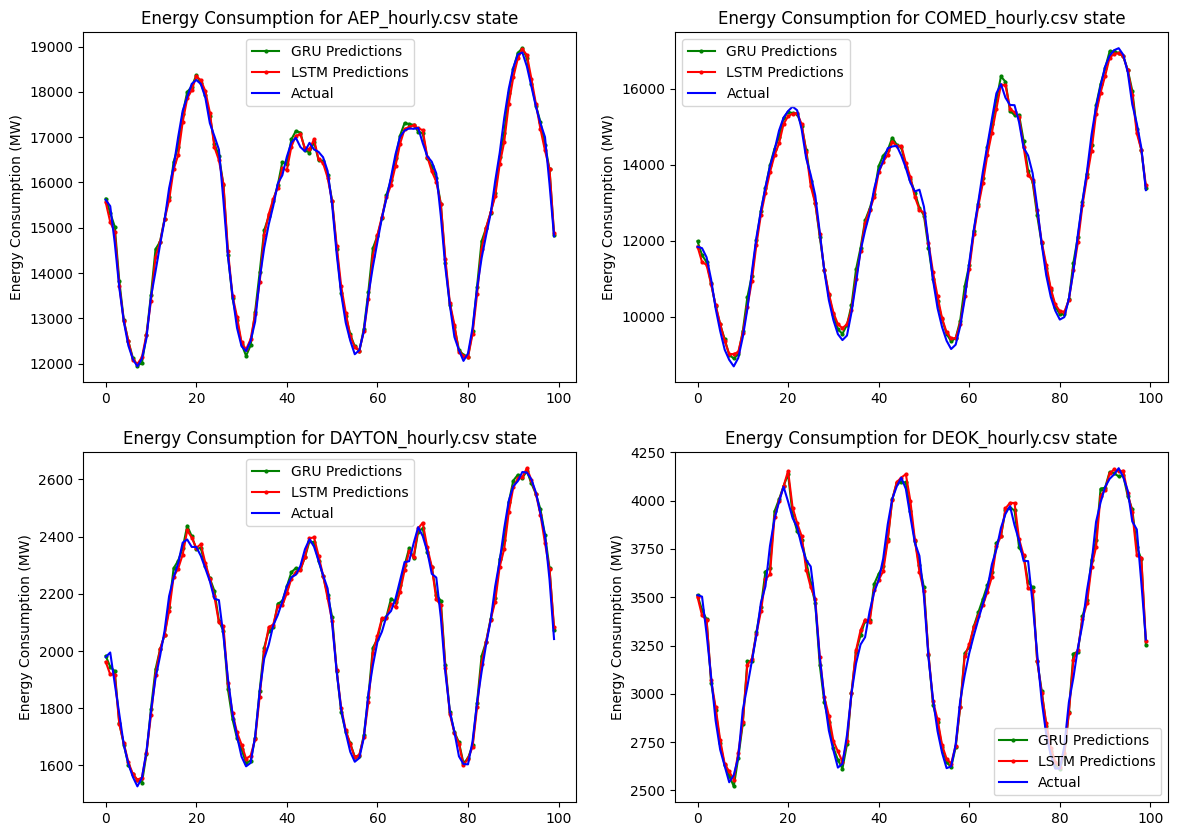

In [34]:
plt.figure(figsize=(14, 10))
plt.subplot(221)
plt.plot(gru_outputs[0][-100:], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[0][-100:], "-o", color='r', label="LSTM Predictions", markersize=2)
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel(f"Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[0]} state")
plt.legend()

plt.subplot(222)
plt.plot(gru_outputs[1][-100:], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[1][-100:], "-o", color='r', label="LSTM Predictions", markersize=2)
plt.plot(targets[1][-100:], color="b", label="Actual")
plt.ylabel(f"Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[1]} state")
plt.legend()

plt.subplot(223)
plt.plot(gru_outputs[2][-100:], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[2][-100:], "-o", color='r', label="LSTM Predictions", markersize=2)
plt.plot(targets[2][-100:], color="b", label="Actual")
plt.ylabel(f"Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[2]} state")
plt.legend()

plt.subplot(224)
plt.plot(gru_outputs[3][-100:], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[3][-100:], "-o", color='r', label="LSTM Predictions", markersize=2)
plt.plot(targets[3][-100:], color="b", label="Actual")
plt.ylabel(f"Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[3]} state")
plt.legend()
plt.show()